<a href="https://colab.research.google.com/github/sunflowerseed17/PythonDSProject/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Loading

In [16]:

# Installing modules, packages and dependencies

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud

In [17]:
# Load Folders containing preprocessed posts

folders = {
    "depression": {
        "path": "preprocessed_depression_posts",
        "label": 1  # Label for depression-related posts
    },
    "breastcancer": {
        "path": "preprocessed_breastcancer_posts",
        "label": 0  # Label for breast cancer posts
    }
}

In [18]:
# Extracting each of the separate posts from the folders (Keeping the 0 or 1 labels in order to differentiate depression and non-depression during feature extraction) 

documents = []
labels = []  # To store corresponding labels for each document

# Iterate through the folders
for category, data in folders.items():
    folder_path = data["path"]
    label = data["label"]
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()  # Read the file content
                documents.append(content)  # Add to documents list
                labels.append(label)  # Add corresponding label

# Check the loaded documents and labels
print(f"Loaded {len(documents)} documents.")
print(f"Labels: {set(labels)}")

Loaded 293 documents.
Labels: {0, 1}


## N-Grams

In [19]:

# Initialize TfidfVectorizer with unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

# Get the feature names (unigrams and bigrams)
feature_names = vectorizer.get_feature_names_out()
print(f"Number of features (unigrams + bigrams): {len(feature_names)}")


Number of features (unigrams + bigrams): 34004


### Unigrams and Bigrams used to capture context (unigrams = single words, bigrams = pairs of words)

In [20]:
# Get feature names and the sum of TF-IDF scores across all documents
feature_names = vectorizer.get_feature_names_out()
tfidf_sums = np.array(tfidf_matrix.sum(axis=0)).flatten()

# Get indices of the top N most common features
top_n = 10  # Adjust to how many common features you want to see
top_indices = np.argsort(tfidf_sums)[-top_n:]  # Indices of top features

# Print the most common features
print(f"Top {top_n} Most Common Features:")
for i in reversed(top_indices):
    print(f"{feature_names[i]}: {tfidf_sums[i]:.4f}")


Top 10 Most Common Features:
feel: 11.5934
like: 10.1414
want: 7.9089
know: 7.1845
year: 6.7375
life: 6.4961
time: 6.0988
feel like: 5.7449
realli: 5.6628
thing: 5.3286


### Extract TF-IDF features, train a logistic regression model with hyperparameter tuning, and identify key features for each category.

In [21]:

# Debugging: Check documents and labels
print(f"Number of valid documents: {len(documents)}")
if documents:
    print(f"Sample document (label {labels[0]}): {documents[0]}")

# Initialize TfidfVectorizer with unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(documents)

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # L1 is not supported by LogisticRegression with liblinear solver
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:")
print(grid_search.best_params_)

# Train the best Logistic Regression model
classifier = grid_search.best_estimator_
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]  # No need to call .toarray() since coef_ is already a numpy array

# Get top 10 positive and negative features
top_positive_indices = np.argsort(coefficients)[-10:]  # Largest coefficients
top_negative_indices = np.argsort(coefficients)[:10]   # Smallest coefficients

print("\nTop 10 Positive Features (indicating depression):")
for i in reversed(top_positive_indices):
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

print("\nTop 10 Negative Features (indicating breast cancer):")
for i in top_negative_indices:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

Number of valid documents: 293
Sample document (label 1): well quit sure begin text realiti unsur anyth brazilian matter reader feel though die insid noth make sens anymor peopl claim highli intellig liar impostor syndrom might make assert seem bias noth foolish young individu gradual destroy metaphys mental navig life faith anyth incap forc use cheer altruist child often refer angel howev seri event cast abyss bottom pit discov trapdoor lead endlessli deep fall devoid prospect return tri good even know good mean truli exist unattract overweight frequent plagu allergi give perpetu sickli appear amount fit train ever succeed boost tri thing shatter refus numb cultur opiat modern though often think life within plato cave might prefer life devoid thought seem sweeter yet stop think sinc grandmoth pass 2022 everyth unravel unsur whether life lost purpos mean signific simpli thing made joy someon love care know continu live neither wish die find place social believ unpleas other claim oppos

### Visualize features from logistic regression model (bar plots and word clouds)




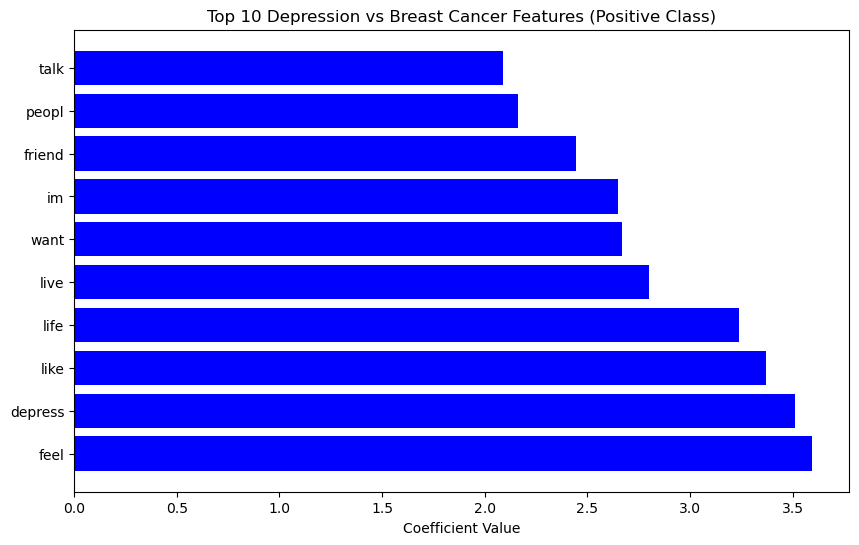

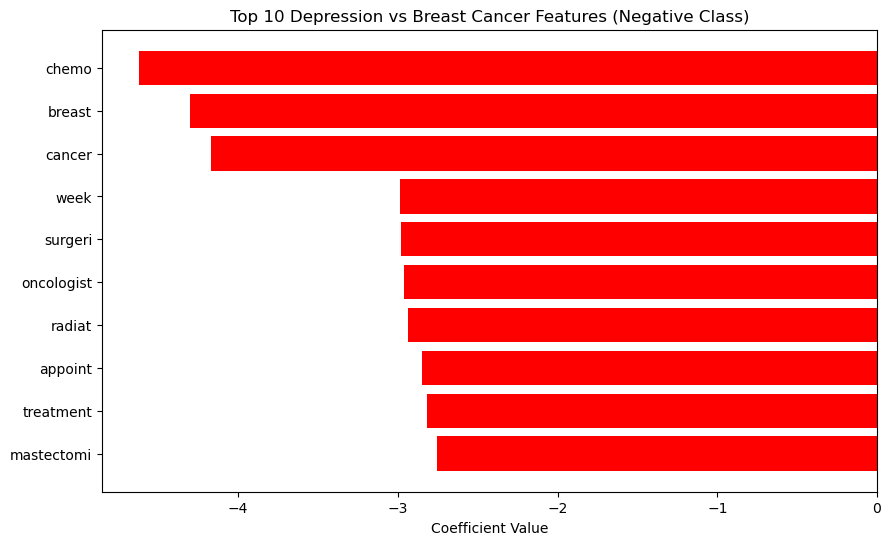

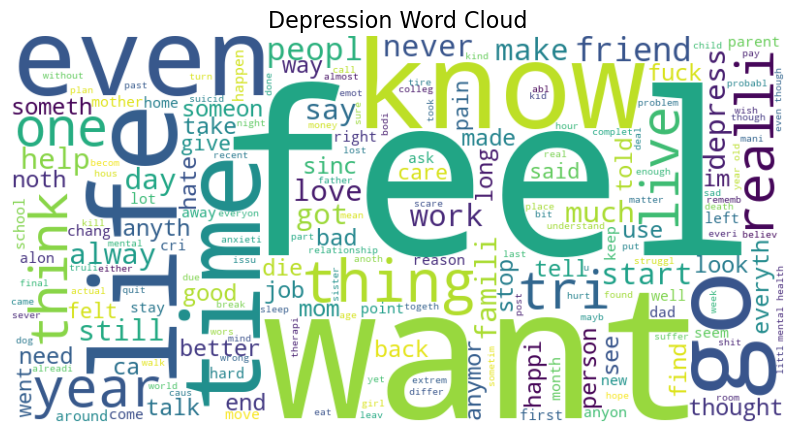

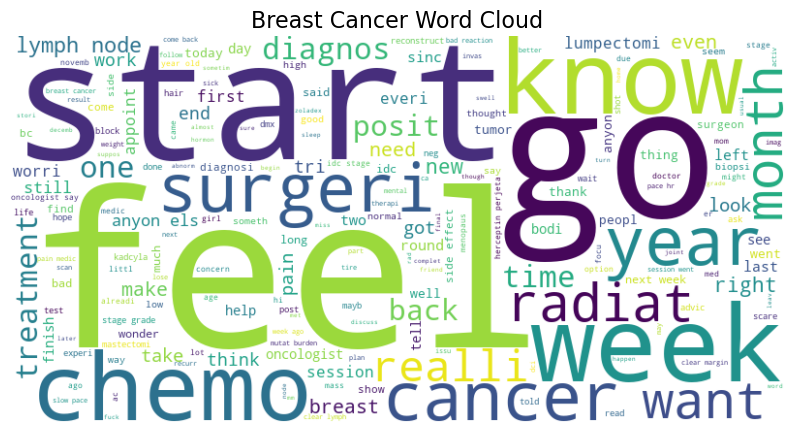

In [22]:

def visualize_features(feature_names, coefficients, title, top_n=10):
    sorted_indices = np.argsort(coefficients)
    top_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[-top_n:]]
    bottom_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[:top_n]]
    
    top_features.reverse()  # Largest first
    bottom_features.reverse()  # Smallest first
    
    # Plot positive features
    plt.figure(figsize=(10, 6))
    plt.barh([f[0] for f in top_features], [f[1] for f in top_features], color='blue')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} {title} Features (Positive Class)")
    plt.show()
    
    # Plot negative features
    plt.figure(figsize=(10, 6))
    plt.barh([f[0] for f in bottom_features], [f[1] for f in bottom_features], color='red')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} {title} Features (Negative Class)")
    plt.show()

visualize_features(feature_names, coefficients, "Depression vs Breast Cancer", top_n=10)

# Generate Word Clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Combine all depression and breast cancer documents
depression_text = " ".join([documents[i] for i in range(len(labels)) if labels[i] == 1])
breast_cancer_text = " ".join([documents[i] for i in range(len(labels)) if labels[i] == 0])

generate_wordcloud(depression_text, "Depression Word Cloud")
generate_wordcloud(breast_cancer_text, "Breast Cancer Word Cloud")


## Empath Feature Extraction

In [127]:
# Installing modules, packages and dependencies

import pandas as pd
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
%pip install empath
from empath import Empath

Note: you may need to restart the kernel to use updated packages.


In [128]:
# Initialising the Empath model

lexicon = Empath()

In [129]:
# Categories to focus on based on the origin paper. 
# The categories are divided into linguistic features, psychological processes, personal concerns, and time orientations.
# Since we cannot use the LIWC tool, we will use the Empath tool and define similar categorical features. 

selected_categories = {
    "linguistic_features": [
        "articles", "auxiliary_verbs", "adverbs", "conjunctions", 
        "personal_pronouns", "impersonal_pronouns", "negations", 
        "prepositions", "verbs", "nouns", "adjectives", 
        "comparatives", "superlatives", "modifiers", "function_words", 
        "filler_words", "verb_tense", "slang", "jargon", 
        "formal_language", "casual_language", "exclamations", 
        "contractions", "word_complexity", "sentiment_words"
    ],
        "psychological_processes": {
        "affective": [
            "positive_emotion", "negative_emotion", "joy", "anger", 
            "sadness", "anxiety", "fear", "disgust", "love", 
            "hope", "trust", "excitement", "anticipation", 
            "relief", "sympathy", "gratitude", "shame", 
            "guilt", "envy", "pride", "contentment", "confusion",
            "boredom", "embarrassment", "longing", "nostalgia", 
            "embarrassment", "frustration", "surprise", "melancholy"
        ],
        "biological": [
            "body", "health", "illness", "pain", "hygiene", 
            "fitness", "exercise", "nutrition", "ingestion", 
            "physical_state", "medicine", "sleep", "sexual", 
            "aging", "disease", "injury", "hospital", "recovery", 
            "dieting", "mental_health", "drug_use", "headache", 
            "fatigue", "hormones", "appetite"
        ],
        "social": [
            "family", "friends", "relationships", "group_behavior", 
            "teamwork", "social_media", "communication", "community", 
            "peer_pressure", "leadership", "parenting", "mentorship", 
            "marriage", "divorce", "gender_roles", "social_identity", 
            "cultural_rituals", "networking", "altruism", "conflict", 
            "social_support", "dominance", "affiliation", "intimacy", 
            "supportiveness", "competition", "conflict_resolution", 
            "collaboration", "in-group", "out-group", "prejudice"
        ],
        "cognitive": [
            "certainty", "doubt", "insight", "cause", "discrepancy", 
            "problem_solving", "creativity", "self_reflection", "planning", 
            "memory", "perception", "attention", "reasoning", "thought_process", 
            "decision_making", "confusion", "learning", "metacognition", "adaptability", 
            "focus", "perspective", "problem_analysis", "evaluation", "interpretation",
            "logic", "intelligence", "rational_thought", "intuition", "conceptualization"
        ],
        "drives": [
            "achievement", "dominance", "affiliation", "control", 
            "self-esteem", "autonomy", "self-assertion", "power", 
            "ambition", "conformity", "subordination", "dependence", 
            "submission", "accomplishment", "independence", "order", 
            "control_seeking", "status", "prosocial_behavior"
        ],
        "spiritual": [
            "spirituality", "faith", "beliefs", "sacred", "religion", 
            "prayer", "meditation", "afterlife", "soul", "divine", 
            "god", "higher_power", "inspiration", "transcendence", 
            "morality", "ethics", "rituals", "holiness", "mindfulness"
        ]
    },
    "personal_concerns": [
        "work", "money", "wealth", "shopping", "career", "travel", 
        "home", "school", "education", "violence", "death", 
        "retirement", "spirituality", "family_life", "hobbies", 
        "volunteering", "pets", "entertainment", "parenting", 
        "sports", "adventure", "politics", "environment", 
        "safety", "technology", "materialism", "status", 
        "self_improvement", "learning", "self_growth", "happiness", 
        "life_purpose", "work_life_balance", "stress", "coping", 
        "job_satisfaction", "ambition", "legacy", "job_search", 
        "unemployment", "retirement_plans", "mental_health", "dating", 
        "romantic_relationships", "divorce", "life_stressors", "transitions"
    ],
    "time_orientations": [
        "present", "past", "future", "morning", 
        "afternoon", "evening", "day", "night", 
        "weekdays", "weekends", "seasons", "holidays", 
        "lifespan", "long_term", "short_term", 
        "routine", "historical", "epoch", "momentary", 
        "timeliness", "timelessness", "urgency", 
        "progression", "nostalgia", "anticipation"
    ]
}

In [131]:
# Extracting features

def extract_empath_features(documents, lexicon, selected_categories):
    """
    Extracts Empath features from a list of documents based on selected categories.
    Parameters:
    documents (list of str): A list of documents to analyze.
    lexicon (Empath): An instance of the Empath lexicon for analyzing text.
    selected_categories (dict): A dictionary specifying the categories to extract. 
        It should have the following structure:
        {
            "linguistic_features": list of str,
            "psychological_processes": dict of {subcategory: list of str},
            "personal_concerns": list of str,
            "time_orientations": list of str
        }
    Returns:
    list of dict: A list of dictionaries where each dictionary contains the extracted features for a document.
    """

    features = []
    for doc in documents:
        doc_features = {}
        
        # Linguistic features
        for category in selected_categories["linguistic_features"]:
            doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        # Psychological processes
        for subcategory, categories in selected_categories["psychological_processes"].items():
            for category in categories:
                doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        # Personal concerns
        for category in selected_categories["personal_concerns"]:
            doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        # Time orientations
        for category in selected_categories["time_orientations"]:
            doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        features.append(doc_features)
    return features


In [132]:
# Extracting features for each document

empath_features = extract_empath_features(documents, lexicon, selected_categories)


In [133]:
# Convert features into a DataFrame for analysis
df_features = pd.DataFrame(empath_features)

# Identify constant columns
constant_columns = df_features.columns[df_features.nunique() == 1]

# Remove constant columns
df_features = df_features.drop(columns=constant_columns)
print(f"Removed constant columns: {constant_columns.tolist()}")

if len(set(labels)) == 1:
    raise ValueError("Labels array is constant; cannot compute correlation.")

# Calculate correlation for each feature
correlations = []
p_values = []

for column in df_features.columns:
    try:
        correlation, p_value = pearsonr(df_features[column], labels)
        correlations.append(correlation)
        p_values.append(p_value)
    except ValueError as e:  # Handle constant features (where they have a 1 or 0 for all features, and therefore don't tell us anything)
        if "ConstantInputWarning" in str(e):
            print(f"Skipping constant feature: {column}")
            correlations.append(None)
            p_values.append(None)
        else:
            raise e

# Apply Benjamini-Hochberg correction
_, corrected_p_values, _, _ = smm.multipletests(p_values, alpha=0.05, method="fdr_bh")

Removed constant columns: ['articles', 'auxiliary_verbs', 'adverbs', 'conjunctions', 'personal_pronouns', 'impersonal_pronouns', 'negations', 'prepositions', 'verbs', 'nouns', 'adjectives', 'comparatives', 'superlatives', 'modifiers', 'function_words', 'filler_words', 'verb_tense', 'slang', 'jargon', 'formal_language', 'casual_language', 'exclamations', 'contractions', 'word_complexity', 'sentiment_words', 'anxiety', 'hope', 'excitement', 'relief', 'gratitude', 'guilt', 'boredom', 'embarrassment', 'longing', 'nostalgia', 'frustration', 'melancholy', 'illness', 'fitness', 'nutrition', 'ingestion', 'physical_state', 'medicine', 'aging', 'disease', 'hospital', 'recovery', 'dieting', 'mental_health', 'drug_use', 'headache', 'fatigue', 'hormones', 'appetite', 'relationships', 'group_behavior', 'teamwork', 'community', 'peer_pressure', 'leadership', 'parenting', 'mentorship', 'marriage', 'divorce', 'gender_roles', 'social_identity', 'cultural_rituals', 'networking', 'altruism', 'conflict', '

### Outcome: 47 topics using Empath was appropriate instead of the 67 which the original paper found with LIWC 

## (For Table) Highest correlation results achieved with Empath features

In [140]:
# Create the initial DataFrame with features, correlations, and p-values
result_df = pd.DataFrame({
    "Feature": df_features.columns,
    "Correlation": correlations,
    "P-Value": corrected_p_values
})

# Add significance stars based on P-Value
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    return ''  # No significance

result_df['Significance'] = result_df['P-Value'].apply(significance_stars)

# Filter significant results
significant_results = result_df[result_df['Significance'] != '']

# Map features to their respective categories
def map_features_to_categories(features, selected_categories):
    grouped_results = {}
    for feature in features:
        for category, subcategories in selected_categories.items():
            if isinstance(subcategories, list):  # Flat category
                if feature in subcategories:
                    grouped_results.setdefault(category, []).append(feature)
            elif isinstance(subcategories, dict):  # Nested subcategories
                for subcategory, sub_features in subcategories.items():
                    if feature in sub_features:
                        grouped_results.setdefault(f"{category} - {subcategory}", []).append(feature)
    return grouped_results

# Map features to categories
grouped_results = map_features_to_categories(significant_results['Feature'], selected_categories)

# Format results into a new DataFrame
formatted_results = [
    {
        "Category": category,
        "Feature": feature,
        "Correlation": significant_results.loc[significant_results['Feature'] == feature, 'Correlation'].values[0],
        "P-Value": significant_results.loc[significant_results['Feature'] == feature, 'P-Value'].values[0],
        "Significance": significant_results.loc[significant_results['Feature'] == feature, 'Significance'].values[0],
    }
    for category, features in grouped_results.items()
    for feature in features
]

# Create the final formatted DataFrame
table_df = pd.DataFrame(formatted_results).sort_values(by=["Category", "Correlation"], ascending=[True, False])

# Add a combined "Correlation (P-Value)" column for display
table_df['Correlation (P-Value)'] = table_df.apply(
    lambda row: f"{row['Correlation']:.2f} ({row['Significance']})", axis=1
)

# Select relevant columns for display
final_table = table_df[['Category', 'Feature', 'Correlation (P-Value)']]

# Display the final table
print(final_table.to_string(index=False))


                            Category          Feature Correlation (P-Value)
                   personal_concerns         violence            0.32 (***)
                   personal_concerns            death            0.27 (***)
                   personal_concerns             work            0.21 (***)
                   personal_concerns         shopping              0.16 (*)
                   personal_concerns             home              0.15 (*)
                   personal_concerns           sports              0.15 (*)
 psychological_processes - affective      contentment            0.33 (***)
 psychological_processes - affective            shame            0.30 (***)
 psychological_processes - affective             love            0.29 (***)
 psychological_processes - affective negative_emotion            0.28 (***)
 psychological_processes - affective positive_emotion            0.28 (***)
 psychological_processes - affective          sadness            0.25 (***)
 psychologic

## Topic Modelling using LDA (Latent Dirichlet Allocation)

In [101]:
#installing modules, packages and dependencies
%pip install gensim
%pip install pyldavis 
%pip install nltk
%pip install plotly
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim import corpora, models
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import IPython.display

# Enable Jupyter Notebook integration
pyLDAvis.enable_notebook()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [102]:
# Separating the documents into depressed and non-depressed

non_depressed_docs = [doc for doc, label in zip(documents, labels) if label == 0]
depressed_docs = [doc for doc, label in zip(documents, labels) if label == 1]

In [108]:

# Download NLTK stopwords and punkt if not already done
nltk.download('stopwords')
nltk.download('punkt')
# Initialize the stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(doc):
    """Tokenize, remove stopwords, and apply stemming."""
    tokens = word_tokenize(doc.lower())  # Tokenize and lowercase the text
    filtered_tokens = [
        stemmer.stem(word) for word in tokens 
        if word.isalpha() and word not in stop_words  # Remove stopwords and non-alphabetic tokens
    ]
    return filtered_tokens

def filter_docs_by_word_count(processed_docs, min_documents):
    """Filter words that appear in more than 'min_documents' docs."""
    word_doc_count = defaultdict(int)
    for doc in processed_docs:
        unique_words = set(doc)
        for word in unique_words:
            word_doc_count[word] += 1
    
    return [
        [word for word in doc if word_doc_count[word] > min_documents] 
        for doc in processed_docs
    ]

def create_corpus_and_dictionary(filtered_docs):
    """Create a dictionary and corpus from the filtered documents."""
    dictionary = corpora.Dictionary(filtered_docs)
    corpus = [dictionary.doc2bow(doc) for doc in filtered_docs]
    return dictionary, corpus

def train_lda(corpus, dictionary, num_topics=70, passes=15):
    """Train an LDA model."""
    return LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

def process_and_train_lda(docs, min_documents=10, num_topics=70, passes=15):
    """Preprocess, filter, and train LDA on the provided documents."""
    processed_docs = [preprocess(doc) for doc in docs]  # Preprocess documents
    filtered_docs = filter_docs_by_word_count(processed_docs, min_documents)  # Filter docs by word count
    dictionary, corpus = create_corpus_and_dictionary(filtered_docs)  # Create corpus and dictionary
    lda_model = train_lda(corpus, dictionary, num_topics, passes)  # Train LDA model
    return lda_model, dictionary, corpus

# Train LDA models for depressed and non-depressed documents
lda_non_depressed, non_depressed_dictionary, non_depressed_corpus = process_and_train_lda(non_depressed_docs)
lda_depressed, depressed_dictionary, depressed_corpus = process_and_train_lda(depressed_docs)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nataszasiwinska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nataszasiwinska/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [111]:
NUM_TOPICS = 30  # Reduce to a manageable number

# Modify the process_and_train_lda function to use the adjusted number of topics
lda_non_depressed, non_depressed_dictionary, non_depressed_corpus = process_and_train_lda(
    non_depressed_docs, min_documents=10, num_topics=NUM_TOPICS, passes=15
)

lda_depressed, depressed_dictionary, depressed_corpus = process_and_train_lda(
    depressed_docs, min_documents=10, num_topics=NUM_TOPICS, passes=15
)

def visualize_lda(lda_model, corpus, dictionary):
    """Visualize the LDA model directly in the notebook."""
    vis = gensimvis.prepare(lda_model, corpus, dictionary)
    return vis  # Return the visualization object

# Visualize for non-depressed topics
print("Visualizing Non-Depressed Topics:")
visualize_lda(lda_non_depressed, non_depressed_corpus, non_depressed_dictionary)

Visualizing Non-Depressed Topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.032277 -0.143206       1        1  11.296808
9      0.113856  0.036706       2        1   9.740699
16    -0.214761 -0.032514       3        1   8.246734
0     -0.131292  0.056164       4        1   7.471398
6      0.121297 -0.018064       5        1   5.622537
28     0.121098  0.031834       6        1   5.408452
25    -0.072412 -0.008940       7        1   5.373661
1     -0.059369 -0.029353       8        1   5.088911
11    -0.204900  0.108257       9        1   4.733563
20     0.129837 -0.049368      10        1   4.609046
14     0.066765 -0.184120      11        1   4.366773
13    -0.013919  0.060914      12        1   3.350383
18    -0.023401 -0.128401      13        1   3.337655
2      0.033360  0.055905      14        1   2.982721
8      0.011648 -0.035287      15        1   2.350280
3      0.061910  0.005637      16        1   2.220495
23    -0.020577 -0.018851      17        1   2.125013
17     0.205544  0.021771      18        1   1.920579
21     0.039780 -0.187174      19        1   1.563804
15     0.148525  0.248445      20        1   1.443882
4     -0.061237 -0.159001      21        1   1.257249
29    -0.261266  0.071391      22        1   1.186258
10     0.040648  0.120756      23        1   1.057964
19     0.001930 -0.210826      24        1   0.856267
12     0.095516  0.139439      25        1   0.852331
22     0.011811  0.103626      26        1   0.715405
26    -0.099038  0.096659      27        1   0.400766
24    -0.024542  0.015867      28        1   0.140122
5     -0.024542  0.015867      29        1   0.140122
27    -0.024542  0.015867      30        1   0.140122, topic_info=      Term       Freq      Total Category  logprob  loglift
29    need  18.000000  18.000000  Default  30.0000  30.0000
31   round  18.000000  18.000000  Default  29.0000  29.0000
44    week  49.000000  49.000000  Default  28.0000  28.0000
5     feel  48.000000  48.000000  Default  27.0000  27.0000
6      get  43.000000  43.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
17    know   0.031316  31.040808  Topic30  -4.1431  -0.3285
19  radiat   0.031316  24.025801  Topic30  -4.1431  -0.0723
22    want   0.031316  23.192726  Topic30  -4.1431  -0.0370
26   chemo   0.031316  26.658379  Topic30  -4.1431  -0.1763
27    even   0.031316  19.381797  Topic30  -4.1431   0.1425

[1174 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
15        1  0.141772  also
15        2  0.189029  also
15        4  0.094514  also
15        5  0.189029  also
15        7  0.094514  also
...     ...       ...   ...
54        7  0.030997  year
54        8  0.030997  year
54       11  0.247978  year
54       13  0.030997  year
54       15  0.061995  year

[556 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 17, 1, 7, 29, 26, 2, 12, 21, 15, 14, 19, 3, 9, 4, 24, 18, 22, 16, 5, 30, 11, 20, 13, 23, 27, 25, 6, 28])

In [112]:
# Visualize for depressed topics
print("Visualizing Depressed Topics:")
visualize_lda(lda_depressed, depressed_corpus, depressed_dictionary)

Visualizing Depressed Topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.009545  0.004970       1        1  17.519487
4     -0.042054  0.031717       2        1  14.380275
24     0.025280 -0.067419       3        1  14.351808
17    -0.018717  0.022277       4        1  12.287879
13     0.007432  0.011783       5        1   7.916286
11    -0.012944  0.010883       6        1   7.166138
18     0.047642  0.005911       7        1   3.817191
21    -0.016261  0.074741       8        1   2.909685
14    -0.038405  0.043863       9        1   2.573700
9     -0.161606 -0.014133      10        1   2.127883
12    -0.072418  0.101786      11        1   1.526828
8      0.006816 -0.002702      12        1   1.461224
23    -0.099446  0.007107      13        1   1.312949
10    -0.039732  0.019282      14        1   1.257147
27    -0.079389  0.048728      15        1   1.140145
5     -0.102578 -0.155401      16        1   0.990058
25    -0.088510 -0.022019      17        1   0.931338
20    -0.050736 -0.238953      18        1   0.914437
3     -0.000454  0.044494      19        1   0.883905
22     0.056023  0.021964      20        1   0.841797
26     0.083430 -0.094434      21        1   0.818104
2     -0.046247  0.030589      22        1   0.737602
29    -0.014883 -0.000154      23        1   0.724325
15     0.147677  0.058685      24        1   0.320214
28     0.181542 -0.127123      25        1   0.319017
16     0.080788  0.087022      26        1   0.250172
7      0.019369  0.107509      27        1   0.224601
6      0.132934 -0.006634      28        1   0.136032
19     0.025452 -0.022461      29        1   0.132417
1      0.079541  0.018121      30        1   0.027357, topic_info=      Term        Freq       Total Category  logprob  loglift
14    feel  647.000000  647.000000  Default  30.0000  30.0000
104   like  594.000000  594.000000  Default  29.0000  29.0000
23    know  365.000000  365.000000  Default  28.0000  28.0000
53   think  212.000000  212.000000  Default  27.0000  27.0000
158  would  322.000000  322.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
84     day    0.016060  206.331614  Topic30  -6.1543  -1.2570
133   work    0.015924  171.254423  Topic30  -6.1628  -1.0791
210    end    0.015658  114.013912  Topic30  -6.1796  -0.6892
80   could    0.015791  167.754190  Topic30  -6.1712  -1.0669
14    feel    0.015646  647.951242  Topic30  -6.1804  -2.4274

[1614 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
160       1  0.060260      abl
160       2  0.120520      abl
160       3  0.020087      abl
160       4  0.140607      abl
160       5  0.120520      abl
...     ...       ...      ...
471       6  0.136324  younger
471       7  0.204486  younger
471      14  0.068162  younger
471      17  0.068162  younger
471      21  0.068162  younger

[4852 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 25, 18, 14, 12, 19, 22, 15, 10, 13, 9, 24, 11, 28, 6, 26, 21, 4, 23, 27, 3, 30, 16, 29, 17, 8, 7, 20, 2])

### Outcomes: 30 topics using LDA was appropriate instead of the 70 which the original paper found 